#Product assortment:


Imagine that you are produce $n$ product types. Every week you can choose which products will be offered (indicated by $x_i$ variable). For each product there is an associated profit per unit $p_i$. Further, every week there is a certain demand for the product $d_i$ coming from log-Gaussian distribution:

$$
\log d_i | \theta, x \sim N((\theta x)_i, \sigma^2)
$$

Some of your products might complement each other (and thus their sales positively correlate with each other) or be substitutes (and thus their sales negatively correlate with each other). For examply, most likely bread and milk are bought together while Paracetamol and alcohol are less likely to be bought together ~~(unless someone wants to die)~~.


Refer to [Section 7.2 of the tutorial](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf) to complete exercises.

In [9]:
import numpy as np
import io
import cv2
from scipy.stats import beta
import matplotlib.pyplot as plt
import random
import copy
import itertools


### Exercise 1:
Complete the following code to do sample demand and compute reward.

In [25]:
class RewardProductAssortment:
    def __init__(self, theta, var):
        self.n = theta.shape[0]  # number of products
        self.profit = 1 / self.n  # profit associated to each product
        self.var = var
        self.theta = copy.deepcopy(theta)

    def get(self, x):
        demands, rewards = [], []
        for i in range(self.n):
            if x[i] != 0:
                # Sample demand from log-Gaussian distribution
                log_di = np.random.normal(np.dot(self.theta[i], x), np.sqrt(self.var))
                d_i = np.exp(log_di)  # Convert log demand to actual demand
                reward = d_i * self.profit  # Compute reward
                demands.append(d_i)
                rewards.append(reward)
        return demands, rewards


### Exercise 2:
Complete the following code to compute expected profit.

In [26]:
class TSProductAssortment:
    def __init__(self, n, var):
        self.n = n  # number of products
        self.var = var

        # parameters of prior distribution. We try to represent a matrix of size n by n
        self.mu_0 = np.zeros(n*n)
        self.cov_0 = np.eye(n*n) + np.sqrt(var) * (np.ones((n*n,n*n)) - np.eye(n*n))

        self.profit = 1 / n  # equal profit for each product

    def select_assortment(self):
        expected_profits = []
        x_value = [0, 1]
        x_vectors = list(itertools.product(x_value, repeat=self.n))
        theta = np.random.multivariate_normal(self.mu_0, self.cov_0).reshape(self.n, self.n)

        for x in x_vectors:
            x = np.array(x)
            log_d = np.dot(theta, x)
            d = np.exp(log_d)  # Convert log demand to actual demand
            expected_profit = np.dot(d, self.profit * x)
            expected_profits.append(expected_profit)

        if not expected_profits:
            print("Error: expected_profits is empty")
        else:
            print("expected_profits:", expected_profits)

        return x_vectors[np.argmax(expected_profits)]  # select products based on the highest expected profit

    def update(self, selected_products, demand, reward):
        selected_products = list(selected_products)
        selected_ids = [i for i, s in enumerate(selected_products) if s == 1]

        # create a selection matrix
        S = np.zeros((len(demand), self.n))
        for j in range(len(demand)):
            i = selected_ids[j]
            S[j,i] = 1 if selected_products[i] == 1 else 0

        # create a matrix W by taking the Kronecker product of selected_products and S
        W = np.kron(selected_products, S)

        # create a vector z taking the natural log of demands
        z = np.log(demand)

        # update the mean and covariance of the prior distribution
        cov_n_inv = np.linalg.inv(self.cov_0) + (1 / self.var) * W.T @ W
        cov_n = np.linalg.inv(cov_n_inv)
        mu_n = cov_n @ (np.linalg.inv(self.cov_0) @ self.mu_0 + (1 / self.var) * W.T @ z)

        self.mu_0 = mu_n
        self.cov_0 = cov_n

In [33]:
# Define the parameters
n = 6
var = 0.04
num_iterations = 500

theta = np.array(
[[1.23207994,-0.06103542,0.60034175,0.26453487,0.12652134,0.05237662],
[-0.06103542,3.71989617,-0.11812647,-2.04080272,2.85785816,-0.58437546],
[0.60034175,-0.11812647,1.89051133,-0.7754829,0.36348837,-0.39664255],
[0.26453487,-2.04080272,-0.7754829,4.806801,-2.4103273,0.63538556],
[0.12652134,2.85785816,0.36348837,-2.4103273,3.92416858,0.18912621],
[0.05237662,-0.58437546,-0.39664255,0.63538556,0.18912621,1.50256759]]
)

rewards_for_pa = RewardProductAssortment(theta, var)

ts = TSProductAssortment(n, var)
rewards = []

for t in range(num_iterations):
    # Select product assortment
    reward_total = 0
    chosen_products = ts.select_assortment()
    # Get demand and reward values for chosen products
    demand, reward = rewards_for_pa.get(chosen_products)

    # Get the total reward
    for i in range(len(reward)):
        reward_total += reward[i]
    rewards.append(reward_total)

    # Update algorithm
    ts.update(chosen_products, demand, reward)

cumulative_rewards = np.cumsum(rewards)
average_rewards = cumulative_rewards / (np.arange(num_iterations) + 1)

expected_profits: [0.0, 0.031173024246125385, 0.10993180828876233, 0.35125024412058253, 0.019288973963096846, 0.07683555130360982, 0.17139569943403385, 0.6677360712707077, 0.051075871779636836, 0.06832603532143201, 0.21534148615443735, 0.3446527160169604, 0.06663770123675046, 0.10219609719286875, 0.2688041460976285, 0.565420364502682, 0.3223611777293667, 0.26622258746356436, 0.9306052642178497, 0.8678174498180132, 2.617575162609551, 2.0617308388922684, 7.185578755203169, 5.858080275544615, 0.06771567629813209, 0.06853910891970384, 0.21030283045121834, 0.26474936233899315, 0.3460101653778564, 0.29885358247591987, 0.9402411140681518, 0.931455398408414, 0.06471810903350438, 0.043029007719547235, 0.17676710843319476, 0.39923201814164694, 0.22142349406286785, 0.1033459814451828, 0.2924602923827671, 0.7457023550687973, 0.11140104792788508, 0.09105027805021776, 0.3093285336339414, 0.4106534573675885, 0.21241753202356672, 0.12691285133085578, 0.3938064320148247, 0.642607207419236, 3.2448232554

In [35]:
assert len(chosen_products) == n, "Selected products array length should match number of products"
assert len(demand) == len(reward), "Demand and reward lists should be of the same length"
assert rewards[-1] >= 0, "Reward should be non-negative"

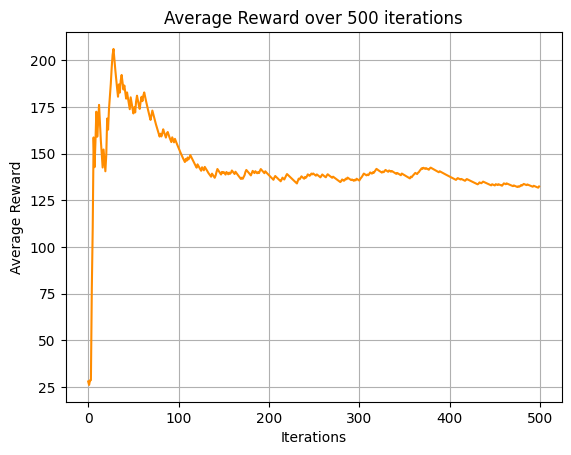

In [ ]:
# plot the average rewards obtained per iteration
plt.plot(average_rewards, color='darkorange')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title(f'Average Reward over {num_iterations} iterations')
plt.show()

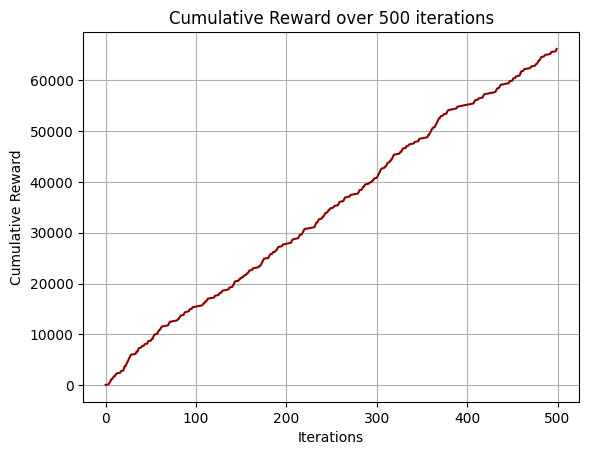

In [ ]:
# plot the cumulative rewards obtained per iteration
plt.plot(cumulative_rewards, color='darkred')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Reward')
plt.title(f'Cumulative Reward over {num_iterations} iterations')
plt.show()

In [34]:
assert len(average_rewards) == num_iterations, "Average rewards array length should match number of iterations"
assert len(cumulative_rewards) == num_iterations, "Cumulative rewards array length should match number of iterations"
assert cumulative_rewards[-1] >= 0, "Final cumulative reward should be non-negative"